In [1]:
import pickle
import datetime
from dateutil.relativedelta import relativedelta
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from numpy import array
import tensorflow as tf
import warnings
from tqdm import tqdm_notebook as tqdm
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly as py
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pylab as plt
import math
import pickle
import os
import pandas as pd
import folium
import math
import numpy as np
import matplotlib
import covsirphy as cs
from itertools import cycle
sns.set()
matplotlib.use('nbagg')
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
import covsirphy as cs

# Download datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()
population_data = data_loader.population()

In [3]:
train = jhu_data.cleaned()
countries = train["Country"].unique()
total_data = []
days_moving_average = 3


for country in countries:
    try:
        s = cs.Scenario(jhu_data, population_data, country=country)
        s.complement()
        diff = s.records_diff(variables=["Confirmed"], window=days_moving_average, show_figure=False)
        d = s.records(show_figure=False)
        
        # Add country name and number of new confirmed cases
        d["Country"] = country
        d["New Confirmed"] = diff.reset_index()["Confirmed"]
        d = d[:-3]
        total_data.append(d)
    except:
        print(country + " not found")
        

American Samoa not found
Others not found
South Korea not found
Tajikistan not found


In [4]:
train_df = pd.concat(total_data)
train_df.head()

,Date,Confirmed,Infected,Fatal,Recovered,Country,New Confirmed
0,2020-03-20,29,28,0,1,Afghanistan,4.0
1,2020-03-21,30,29,0,1,Afghanistan,4.0
2,2020-03-22,34,32,1,1,Afghanistan,14.0
3,2020-03-23,41,39,1,1,Afghanistan,13.0
4,2020-03-24,43,41,1,1,Afghanistan,16.0


In [ ]:
def pred(model, data):
    y_pred = model.predict(data)
    return y_pred


def forcast(model, data, start_date, num_days, n_steps, regs):
    """
    Utility method for Forcasting
    model - trained model on Confirmed/Deaths data
    start_date - Starting date of forcasting
    num_days - Number of days for which forcasting is required
    """
    res_ = dict()
    for i in range(len(data)):
        res_[i] = []
    y_pred = pred(model, data)
    dates = []
    date1 = datetime.datetime.strptime(start_date, "%Y-%m-%d")

    for j in range(1, num_days+1):
        for i in range(len(data)):
            cur_window = list(data[i][0][1: n_steps+1])
            res_[i].append(cur_window[-1])
            cur_window.append(y_pred[i])
            data[i][0] = cur_window
        y_pred = pred(model, data)
        dates.append(date1.strftime("%Y-%m-%d"))
        date1 += relativedelta(days=1)
    res = pd.DataFrame(pd.DataFrame(pd.DataFrame(res_).values.T))
    res.columns = dates
    res['Country/State'] = regs
    return res


def get_countrywise_forcast_(
    covid_timeseries,
    res_regional,
    target,
    country_name,
    state_name,
    num_days,
    begin_date,
    ):
    temp = covid_timeseries[covid_timeseries['Country/Region']
                            == country_name].query('ObservationDate>='
            + begin_date)
    x_truth = temp.ObservationDate
    y_truth = temp[target]
    pred_ = res_regional[res_regional['Country/Region'] == country_name]
    x_pred = pred_.Date[0:num_days]
    y_pred = (pred_[target])[0:num_days]
    return (list(x_truth), list(y_truth), list(x_pred), list(y_pred))



def get_countrywise_forcast(
    train,
    res_regional,
    country_name,
    state_name,
    num_days,
    begin_date,
    ):
    temp = train[train['Country/Region']
                 == country_name].query('ObservationDate>='
            + begin_date)
    x_truth = temp.ObservationDate
    y_truth = temp.Confirmed
    pred_ = res_regional[res_regional['Country/Region'] == country_name]
    x_pred = pred_.Date[0:num_days]
    y_pred = pred_.ConfirmedCases[0:num_days]
    return (list(x_truth), list(y_truth), list(x_pred), list(y_pred))


# Call only when forcast and submission data are available
def get_countrywise_forcast_Deaths(country_name, state_name, num_days):
    temp = train[(train['Country/Region'] == country_name)
                 & (train['Province/State']
                 == state_name)].query('ObservationDate>=' + pivot_date)
    x_truth = temp.ObservationDate
    y_truth = temp.Deaths
    pred_ = res_regional[(res_regional['Country_Region']
                         == country_name)
                         & (res_regional['Province_State']
                         == state_name)]
    x_pred = pred_.Date[0:num_days]
    y_pred = pred_.Fatalities[0:num_days]
    return (list(x_truth), list(y_truth), list(x_pred), list(y_pred))


# Utility Method to convert newly added prediction to cumulative [Not Accurate]
def get_cumulative_confirmed_cases(world_data_):
    world_data_ = world_data_.sort_values(['Country_Region', 'Date'])
    world_data_['Cumulative Confirmed'] = world_data_['New Confirmed']
    for i in tqdm(range(1, len(world_data_))):
        if world_data_['Country_Region'].iloc[i] \
            != world_data_['Country_Region'].iloc[i - 1]:
            world_data_['Cumulative Confirmed'].iloc[i] = \
                world_data_['ConfirmedCases'].iloc[i]
    for i in tqdm(range(1, len(world_data_))):
        if world_data_['Country_Region'].iloc[i] \
            == world_data_['Country_Region'].iloc[i - 1]:
            world_data_['Cumulative Confirmed'].iloc[i] = \
                world_data_['Cumulative Confirmed'].iloc[i] \
                + world_data_['Cumulative Confirmed'].iloc[i - 1]
    return world_data_


# function to create training data for LSTM
# We will take last 7 days Cases as input and 8th day's case as output
def create_train_dataset(target, n_steps, train, pivot_date,
                         unique_regions, states_per_regions):
    train = train.query("ObservationDate<"+pivot_date)
    x, y =[], []
    for k in tqdm(range(len(unique_regions))):
        for state in states_per_regions[k]:
            temp = train[(train['Country/Region'] == unique_regions[k])]
            sequence = list(temp[target])
            for i in range(len(sequence)):
                end_ix = i + n_steps
                if end_ix > len(sequence) - 1:
                    break
                seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
                if(seq_y != 0):
                    x.append(seq_x)
                    y.append(seq_y)
    return array(x), array(y)


def create_countrywise_newly_added_train_dataset(target,
                                                n_steps,
                                                train,
                                                pivot_date):
    train = train.query("ObservationDate<"+pivot_date)
    x, y = [], []
    for k in tqdm(range(len(unique_regions))):
        temp = train[(train['Country/Region']==unique_regions[k])]
        sequence = list(temp[target])
        for i in range(len(sequence)):
            end_ix = i + n_steps
            if end_ix > len(sequence)-1:
                break
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
            if( seq_y != 0):
                x.append(seq_x)
                y.append(seq_y)
    return array(x), array


def create_test_dataset_new_c(target, n_steps, train,pivot_date, unique_regions,
                        states_per_regions):
    train = train.query("ObservationDate<"+pivot_date)
    x, regs = [], []
    for k in tqdm(range(len(unique_regions))):
        for state in states_per_regions[k]:
            temp = train[(train['Country/Region'] == unique_regions[k])]
            sequence = temp[target].values
            x.append(sequence[len(sequence)-n_steps:len(sequence)+1])
            regs.append((unique_regions[k],state))  
    return x, regs


def create_test_dataset(target, n_steps, train,pivot_date, unique_regions,
                        states_per_regions):
    """
    Function to create test dataset
    our supervised probem is now given last 7 days data predict 
    the no of cases for 8th day;
    target : 'Confirmed'/'Deaths'
    """

    train = train.query("ObservationDate<"+pivot_date)
    x, regs = [], []
    for k in tqdm(range(len(unique_regions))):
        for state in states_per_regions[k]:
            temp = train[(train['Country/Region'] == unique_regions[k])]
            sequence = temp[target].values
            x.append(sequence[len(sequence)-n_steps:len(sequence)+1])
            regs.append((unique_regions[k],state))  
    return x, regs


def create_countrywise_newly_added_test_dataset(target,n_steps,train,pivot_date):
    train = train.query("ObservationDate<"+pivot_date)
    x=[]
    regs=[]
    for k in tqdm(range(len(unique_regions))):
        temp=train[(train['Country/Region']==unique_regions[k])]
        sequence=temp[target]
        #print(sequence[len(sequence)-n_steps:len(sequence)+1])
        x.append(sequence[len(sequence)-n_steps:len(sequence)+1])
        regs.append(unique_regions[k])      
    return array(x),regs

def get_newly_added(world_data_):
    world_data_=world_data_.sort_values(['Country/Region','ObservationDate'])
    temp=[0*i for i in range(len(world_data_))]
    world_data_['New Confirmed']=temp
    world_data_['New Death']=temp
    for i in tqdm(range(1,len(world_data_))):
        if(world_data_['Country/Region'].iloc[i]==world_data_['Country/Region'].iloc[i-1]):
            if(world_data_['Deaths'].iloc[i]<world_data_['Deaths'].iloc[i-1]):
                world_data_['Deaths'].iloc[i]=world_data_['Deaths'].iloc[i-1]
            if(world_data_['Confirmed'].iloc[i]<world_data_['Confirmed'].iloc[i-1]):
                world_data_['Confirmed'].iloc[i]=world_data_['Confirmed'].iloc[i-1]     
            world_data_['New Confirmed'].iloc[i]=world_data_['Confirmed'].iloc[i]-world_data_['Confirmed'].iloc[i-1]
            world_data_['New Death'].iloc[i]=world_data_['Deaths'].iloc[i]-world_data_['Deaths'].iloc[i-1]
        else:
            world_data_['New Confirmed'].iloc[i]=world_data_['Confirmed'].iloc[i]
            world_data_['New Death'].iloc[i]=world_data_['Deaths'].iloc[i]
    return world_data_

def list_per_region(train):
  # Creating list of all regions of all counntries
    unique_regions = train['Country/Region'].unique()
    states_per_regions = []
    for reg in tqdm(unique_regions):
        states_per_regions.append(
            train[train['Country/Region'] == reg]['Country/Region'].unique())
    return states_per_regions, unique_regions

def prepare_submission(res_c, res_d, res_nc, test, pivot_date, end_date): 
    test = test.query("Date>="+pivot_date)
    test = test.query("Date<="+end_date)
    index=dict()
    for i in range(len(res_c)):
        index[res_c.iloc[i]['Country/State'][0]]=i
    pred_c=[]
    pred_d=[]
    pred_nc=[]
    for i in tqdm(range(len(test))):
        if(test.iloc[i]['Country/Region'] in index):
            loc=index[test.iloc[i]['Country/Region']]
            date = datetime.datetime.strftime(test.iloc[i]['Date'].date(), format="%Y-%m-%d")
            
            pred_c.append(res_c.iloc[loc][date])     
            pred_d.append(res_d.iloc[loc][date]) 
            pred_nc.append(res_nc.iloc[loc][date]) 

    test['ConfirmedCases']=pred_c
    test['Fatalities']=pred_d
    test['New Confirmed']=pred_nc
    res_regional=test
    res=test.drop(columns=['Country/Region','Date','New Confirmed'])
    return res, res_regional

def convert_predictions_df(res_c, res_d, res_nc, test, pivot_date, end_date):
    test = test.query("Date>="+pivot_date)
    test = test.query("Date<="+end_date)
    index=dict()
    for i in range(len(res_nc)):
        index[res_nc.iloc[i]['Country/State'][0]]=i

    pred_c, pred_d, pred_nc=[], [], []
    for i in tqdm(range(len(test))):
        if(test.iloc[i]['Country/Region'] in index):
            loc=index[test.iloc[i]['Country/Region']]
            date = datetime.datetime.strftime(test.iloc[i]['Date'].date(), format="%Y-%m-%d")
            pred_nc.append(res_nc.iloc[loc][date]) 
            pred_c.append(res_c.iloc[loc][date]) 
            pred_d.append(res_d.iloc[loc][date]) 
    
    test["Confirmed"] = pred_c
    test['New Confirmed'] = pred_nc
    test["Deaths"] = pred_d
   
    res_regional=test
    res=test.drop(columns=['Country/Region','Date','New Confirmed'])
    return res, res_regional

def convert_predictions_nc(res_nc, test, pivot_date, end_date):
    test = test.query("Date>="+pivot_date)
    test = test.query("Date<="+end_date)
    index=dict()
    for i in range(len(res_nc)):
        index[res_nc.iloc[i]['Country/State'][0]]=i

    pred_c, pred_d, pred_nc=[], [], []
    for i in tqdm(range(len(test))):
        if(test.iloc[i]['Country/Region'] in index):
            loc=index[test.iloc[i]['Country/Region']]
            date = datetime.datetime.strftime(test.iloc[i]['Date'].date(), format="%Y-%m-%d")
            pred_nc.append(res_nc.iloc[loc][date]) 
    
    test['New Confirmed'] = pred_nc
   
    res_regional=test
    res=test.drop(columns=['Country/Region','Date','New Confirmed'])
    return res, res_regional

# Hyperparameter tuning

In [172]:

# epochs = [10, 20]
# batch_sizes = [24, 32, 64]
# n_hiddens = [12, 32, 42]
epoch = 18
batch_size = 36
n_hidden = 36

MAE, MSE, RMSE, R2 = {}, {}, {}, {}
target = "New Confirmed"
countries = train_df["Country"].unique()

# for epoch in epochs:
#     for batch_size in batch_sizes:
#         for n_hidden in n_hiddens:
iteration = str(epoch) + "/" + str(batch_size) +  "/" + str(n_hidden)
print(iteration)

train = train_df.rename(columns={'Country': 'Country/Region','Fatal': 'Deaths', 'Date': 'ObservationDate'})
covid_timeseries = train.copy()

num_cols = ['Confirmed', 'Deaths']
for col in num_cols:
    temp = [int(i) for i in train[col]]
    train[col] = temp

# Create empty test set
countries = train["Country/Region"].unique()
dates = list(train[train["Country/Region"] == countries[0]].ObservationDate)

# Create empty test set
d = []
for country in countries:
    for date in dates:
        d.append(
            {
                'Country/Region': country,
                'Date': date,
            }
        )
test = pd.DataFrame(d)

states_per_regions, unique_regions = list_per_region(test)

# Number of steps to look back
n_steps = 7

# Number of days to forcast
num_days = 120

pivot_date = "'2020-10-01'"


print('Cumulative Confirmed Cases')
X_c, y_c = create_train_dataset('Confirmed', n_steps, train, pivot_date, unique_regions, states_per_regions)

print('Confirmed Cases')
X_nc, y_nc = create_train_dataset('New Confirmed', n_steps, covid_timeseries, pivot_date, unique_regions, states_per_regions)
test_confirmed, regs = create_test_dataset('Confirmed', n_steps, train, pivot_date, unique_regions, states_per_regions)
test_nc, reg_nc = create_test_dataset_new_c('New Confirmed', n_steps, covid_timeseries, pivot_date, unique_regions, states_per_regions)

print('Deaths Cases')
X_d, y_d = create_train_dataset('Deaths', n_steps, train, pivot_date, unique_regions, states_per_regions)
test_deaths, regs = create_test_dataset('Deaths', n_steps, train, pivot_date, unique_regions, states_per_regions)
print('Finished preparing datasets.')

# Split the train data in to train and val data
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(
    X_c, y_c, test_size=0.30, random_state=42)
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(
    X_d, y_d, test_size=0.30, random_state=42)
X_train_nc, X_val_nc, y_train_nc, y_val_nc = train_test_split(
    X_c, y_c, test_size=0.30, random_state=42)

# Reshape data
test_confirmed = pd.DataFrame(test_confirmed).values
test_nc = pd.DataFrame(test_nc).values
test_deaths = pd.DataFrame(test_deaths).values


# Reshapping the Confirmed data for LSTM
X_train_c = X_train_c.reshape((X_train_c.shape[0], 1, X_train_c.shape[1]))
X_val_c = X_val_c.reshape((X_val_c.shape[0], 1,  X_val_c.shape[1]))
X_train_nc = X_train_nc.reshape((X_train_nc.shape[0], 1, X_train_nc.shape[1]))
X_val_nc = X_val_nc.reshape((X_val_nc.shape[0], 1,  X_val_nc.shape[1]))
X_test_c = test_confirmed.reshape(
    (test_confirmed.shape[0], 1, test_confirmed.shape[1]))
X_test_nc = test_nc.reshape((test_nc.shape[0], 1, test_nc.shape[1]))


# Reshapping the donfirmed data for LSTM
X_train_d = X_train_d.reshape((X_train_d.shape[0], 1, X_train_d.shape[1]))
X_val_d = X_val_d.reshape((X_val_d.shape[0], 1,  X_val_d.shape[1]))
X_test_d = test_deaths.reshape((test_deaths.shape[0], 1, test_deaths.shape[1]))

# Initializing model components
timesteps = X_train_c.shape[1]
input_dim = X_train_c.shape[2]
n_features = 1

# Model for Death cases
model_d = Sequential()
model_d.add(LSTM(50, activation='relu', input_shape=(n_features,n_steps),return_sequences=True))
model_d.add(LSTM(50, activation='relu'))
model_d.add(Dense(1))
model_d.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
# hist=model_d.fit(X_train_d,y_train_d, epochs=epoch, batch_size=batch_size, validation_data=(X_val_d, y_val_d), verbose=2, shuffle=True,callbacks=callbacks)


# Model for Confirmed cases
model_c = Sequential()
model_c.add(LSTM(50, activation='relu', input_shape=(n_features,n_steps),return_sequences=True))
model_c.add(LSTM(150, activation='relu'))
model_c.add(Dense(1,activation='relu'))
model_c.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
# fit the model
# hist=model_c.fit(X_train_c,y_train_c, epochs=epoch, batch_size=batch_size, validation_data=(X_val_c, y_val_c), verbose=2, shuffle=True,callbacks=callbacks)

# Model for new confirmed cases
model_nc = Sequential()
model_nc.add(LSTM(50, activation='relu', input_shape=(n_features,n_steps),return_sequences=True))
model_nc.add(LSTM(50, activation='relu'))
model_nc.add(Dense(1))
model_nc.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.6),
            EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
hist=model_nc.fit(X_train_nc,y_train_nc, epochs=epoch, batch_size=batch_size, validation_data=(X_val_nc, y_val_nc), verbose=2, shuffle=True,callbacks=callbacks)


forcast_start_date = pivot_date.replace("'", "")
res_confirmed=forcast(model_c,X_test_c,forcast_start_date, num_days, n_steps, regs)
res_deaths=forcast(model_d,X_test_d,forcast_start_date, num_days, n_steps, regs)
res_new_confirmed = forcast(model_nc,X_test_nc,forcast_start_date, num_days, n_steps, regs)

begin_date = pivot_date
end_date = f"'{res_new_confirmed.columns[-2:][0]}'"

sub, res_regional = convert_predictions_df(res_confirmed, res_deaths, res_new_confirmed, test,begin_date, end_date)
# sub, res_regional = convert_predictions_nc(res_new_confirmed, test, begin_date, end_date)
res_regional = res_regional.rename(columns={"New Confirmed": "New Confirmed_LSTM", "Deaths": "Deaths_LSTM", "Confirmed": "Confirmed_LSTM"})
maes, mses, rmses, r2s = [], [], [], []
for country in countries:
    try:
        Y_pred = res_regional[res_regional["Country/Region"] == country]
        Y_true = train_df[train_df["Country"] == country]
        temp = pd.merge(Y_true, Y_pred, on="Date")
        y, yhat = temp[target + "_LSTM"], temp[target]
        maes.append(metrics.mean_absolute_error(y, yhat))
        mses.append(metrics.mean_squared_error(y, yhat))
        rmses.append(np.sqrt(mse))
        r2s.append(metrics.r2_score(y,yhat))
    except:
        print(country)

MAE[iteration] = np.mean(maes)
MSE[iteration] = np.mean(mses)
RMSE[iteration] = np.mean(rmses)
R2[iteration] = np.mean(r2s)

    

18/36/36



Cumulative Confirmed Cases



Confirmed Cases



Deaths Cases



Finished preparing datasets.
Epoch 1/18
668/668 - 3s - loss: 1.1770 - val_loss: 0.0024
Epoch 2/18
668/668 - 3s - loss: 0.0022 - val_loss: 0.0020
Epoch 3/18
668/668 - 2s - loss: 0.0020 - val_loss: 0.0020
Epoch 4/18
668/668 - 2s - loss: 0.0019 - val_loss: 0.0019
Epoch 5/18
668/668 - 2s - loss: 0.0019 - val_loss: 0.0019
Epoch 6/18
668/668 - 2s - loss: 0.0019 - val_loss: 0.0018
Epoch 7/18
668/668 - 2s - loss: 0.0018 - val_loss: 0.0019
Epoch 8/18
668/668 - 2s - loss: 0.0018 - val_loss: 0.0017
Epoch 9/18
668/668 - 2s - loss: 0.0018 - val_loss: 0.0018
Epoch 10/18
668/668 - 2s - loss: 0.0018 - val_loss: 0.0018
Epoch 11/18
668/668 - 2s - loss: 0.0018 - val_loss: 0.0017
Epoch 12/18
668/668 - 2s - loss: 0.0018 - val_loss: 0.0019
Epoch 13/18

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
668/668 - 2s - loss: 0.0018 - val_loss: 0.0017
Epoch 14/18
668/668 - 2s - loss: 0.0018 - val_loss: 0.0017
Epoch 15/18
668/668 - 2s - loss: 0.0018 - val_loss: 0.0017
Epoch 16/18
6


Marshall Islands
Solomon Islands
Vanuatu
Samoa


MAE 8318.222645803948
MSE 173445876.7353743
RMSE 10288.697884143965
R2 -41.14321274355916


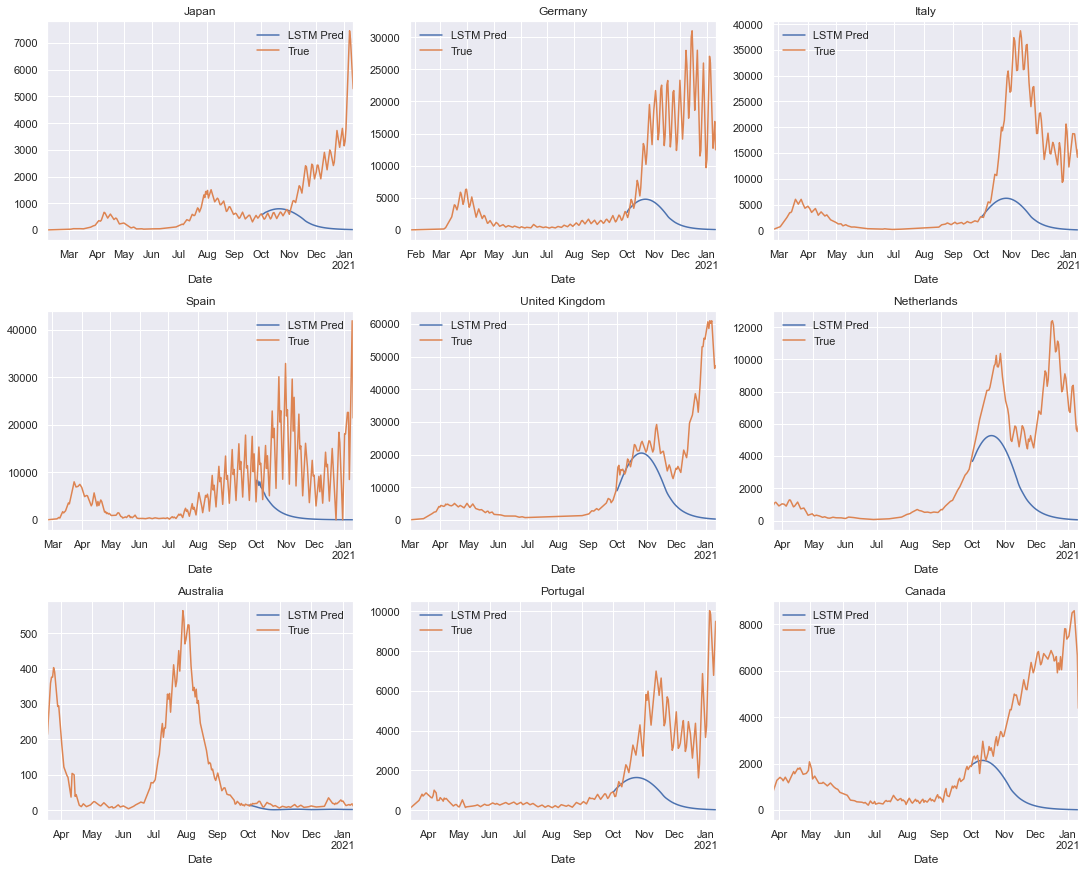

In [125]:
countries = ["Japan", "Germany", "Italy", "Spain", "United Kingdom", "Netherlands", "Australia", "Portugal", "Canada"]
nrow, ncol = 3, 3
colors = map('C{}'.format, cycle(range(nrow*ncol)))
fig, axs = plt.subplots(nrow,ncol,figsize=(ncol*5, nrow*4), constrained_layout=True);
MAE, MSE, RMSE, R2 = [], [], [], []
target = "New Confirmed"
# res_regional = res_regional.rename(columns={"Confirmed": "Confirmed_LSTM", "New Confirmed": "New Confirmed_LSTM", "Deaths": "Deaths_LSTM"})
# res_regional = res_regional.rename(columns={"New Confirmed": "New Confirmed_LSTM"})


for country, ax in zip(countries, axs.flatten()):
    Y_pred = res_regional[res_regional["Country/Region"] == country]
    Y_pred.plot(x="Date", y=target + "_LSTM", label="LSTM Pred", ax=ax)
    Y_true = train_df[train_df["Country"] == country]
    Y_true.plot(x="Date", y=target, ax=ax, label="True", title=country);
    temp = pd.merge(Y_true, Y_pred, on="Date")
    y, yhat = temp[target + "_LSTM"], temp[target]
    
    MAE.append(metrics.mean_absolute_error(y, yhat))
    MSE.append(metrics.mean_squared_error(y, yhat))
    RMSE.append(np.sqrt(metrics.mean_squared_error(y, yhat)))
    R2.append(metrics.r2_score(y,yhat))
    
print("MAE", np.mean(MAE))
print("MSE", np.mean(MSE))
print("RMSE", np.mean(RMSE))
print("R2", np.mean(R2))




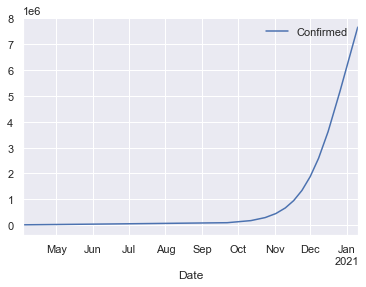

In [191]:
data = pickle.load(open("data/Netherlands_2020-10-01_SIR.p", "rb"))
data["Infected"] = data["Infected"] / 10
data.plot(x="Date", y="Confirmed")

data["New Confirmed"] = data["Confirmed"].diff() 
data = data[:210]

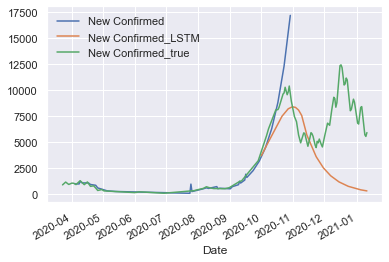

In [192]:
country = "Netherlands"
country_selection_LSTM = res_regional[res_regional["Country/Region"] == country]
train_selection = train_df[train_df["Country"] == country]
train_selection = train_selection.rename(columns={"New Confirmed": "New Confirmed_true"})
merged = pd.merge(data, country_selection_LSTM, on="Date", how="outer")
merged = pd.merge(merged, train_selection[["Date", target + "_true"]], on="Date", how="outer")
merged.plot(x="Date", y=[target, "New Confirmed_LSTM", "New Confirmed_true"])

In [160]:
merged

,Date,Confirmed,Fatal,Infected,Recovered,Country/Region,New Confirmed_LSTM,New Confirmed_true
0,2020-04-03,15563.0,1437.0,959.8,4528.0,NaN,NaN,1015.0
1,2020-04-04,16526.0,1586.0,957.6,5364.0,NaN,NaN,942.0
2,2020-04-05,17486.0,1735.0,955.3,6198.0,NaN,NaN,895.0
3,2020-04-06,18445.0,1884.0,953.1,7030.0,NaN,NaN,983.0
4,2020-04-07,19400.0,2032.0,950.8,7860.0,NaN,NaN,1165.0
...,...,...,...,...,...,...,...,...
290,2020-03-29,NaN,NaN,NaN,NaN,NaN,NaN,906.0
291,2020-03-30,NaN,NaN,NaN,NaN,NaN,NaN,975.0
292,2020-03-31,NaN,NaN,NaN,NaN,NaN,NaN,1037.0
293,2020-04-01,NaN,NaN,NaN,NaN,NaN,NaN,1035.0
